In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train_data.csv
/kaggle/input/titanic/test_data.csv


# Genrating synthetic data for clustering

<AxesSubplot:>

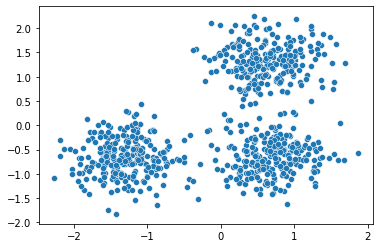

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

#-------------------------------------------------------------------------------
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

ads_arr = StandardScaler().fit_transform(X)
sns.scatterplot(x=ads_arr[:,0],y=ads_arr[:,1])

# K-Means from scratch

### UDF for calculation of distances (Minkowski)

In [3]:
#distance calculation udf
def minkowski_(point_a,point_b,p=2):
    
    if p==1:
        #print('----> Manhattan')
        dist = np.sum(abs(point_a-point_b))
        #print('Manual Distance :',dist)
    elif p==2:
        #print('----> Euclidean')
        dist = np.sqrt(np.sum(np.square(point_a-point_b)))
        #print('Manual Distance :',dist)
        
    return dist

#------------------------------------------------------------------
#UDF for calculation of distance between a point and all other points (including itself)
def distance_to_all(curr_vec,data,p_=2):

    #curr_vec = X_arr[0] #example
    distance_list = []
    #data = X_arr[0:5]

    for vec_idx in range(len(data)):
        dist = minkowski_(point_a=curr_vec,point_b=data[vec_idx],p=p_)
        distance_list.append(dist)

    return distance_list

### UDF for one iteration of K-Means algorithm

In [4]:
def kmeans_unit_process(k,data,centroids,k_dist_arr,p,inertia_tray,inertia,total_dims):
#--------------------------------------------------------------------------------
    #print('i/p (Old) Centroid :\n',centroids)
    
    #Calculating distance of each point from each centre (k value)
    for k in range(k):

        #print(k)
        centroid_k = centroids[k]
        dist = distance_to_all(curr_vec=centroid_k,data=data,p_=2)
        k_dist_arr[:,k] = dist
        
        
    #---------------------------------------------------------
    #Extracting cluster having least distance to each point
    clusters = np.argmin(k_dist_arr,axis=-1)
    clusters = clusters.reshape(k_dist_arr.shape[0],1)
    
    #Extracting the least distance of each point to corresponding cluster
    min_list = np.amin(k_dist_arr,axis=1)
    min_list = min_list.reshape(k_dist_arr.shape[0],1)
    
    #-------------------------------------------------------
    #Appending together
    appended = np.append(k_dist_arr,clusters,axis=-1)
    appended = np.append(appended,min_list,axis=-1)
    
    #-------------------------------------------------------
    #Appending to original data
    data = np.append(data,appended,axis=-1)
    
    #-------------------------------------------------------
    #Unique clusters
    unique_clusters = np.unique(data[:,-2]).astype(int)
    #print(unique_clusters)

    #Extracting new clusters based on previous clusters and distances
    for elem in unique_clusters:
        #print('------------------- Cluster :',elem,'-------------------')
        filtered = data[data[:,-2]==elem]

        c_k = len(filtered)
        k_inertia = np.sum(np.square(filtered[:,-1])) #As per sklearn formula of inertia (contradicting theory)
        inertia += k_inertia

        new_centroid = np.mean(filtered[:,0:total_dims],axis=0)
        #print(total_dims)
        #print('o/p (New) Centroid :',new_centroid)
        centroids[elem] = new_centroid

    #----------------------------------------------------------------------------------------------------------
    #print('o/p (New) Centroid :\n',centroids)
    #print('------- Done for all clusters (x1 iter) -------')
    
    inertia_tray.append(inertia)
    
    #print(np.mean(filtered[:,0:total_dims],axis=0))
    #filtered[:,0:total_dims]
    
    print('Inertia vals over iters :\n',inertia_tray)
    
    return centroids,inertia_tray,clusters

### Overall UDF for K-Means

In [5]:
def Kmeans_manual(k,data,total_dims,seed=None,n_iters=3,tol_val=1e-4):
    
    #--------------------------------------------------------------------------------
    if seed != None:
        np.random.seed(seed)
    
    #Random centroids generated at beginning
    initial_centroids = data[np.random.randint(low=1,high=data.shape[0],size=(k)),:]
    print(initial_centroids.shape)
    
    #--------------------------------------------------------------------------------
    #Internal variable declarations
    k_dist_arr = np.zeros((data.shape[0],k))
    centroids = initial_centroids
    inertia_tray = []

    #Iterative loop based on user-specified iterations
    for n in range(n_iters):

        print('#-------------------- Iter :',n,' -------------------------#')
        inertia = 0
        centroids,inertia_tray,clusters = kmeans_unit_process(k=k,
                                                              data=data,
                                                              centroids=centroids,
                                                              k_dist_arr=k_dist_arr,
                                                              p=2,
                                                              inertia_tray=inertia_tray,
                                                              inertia=inertia,
                                                              total_dims=total_dims)
        
        #Early stopping of the process if the inertia is not imporoving beyond the tolerance value specified
        if n>1:
            diff = inertia_tray[-2] - inertia_tray[-1]
            print('Diff of inertia :',diff)
            if diff<=tol_val:
                print('Interrupting loop at iter :',n)
                break
                
    return clusters,centroids


## Invoking UDF for K-Means Clustering

In [6]:
clusters_,centers = Kmeans_manual(k=3,data=ads_arr,
                                  total_dims=ads_arr.shape[1],
                                  seed=50,n_iters=50,tol_val=1e-4)
clusters_ = clusters_.ravel()
len(clusters_)

(3, 2)
#-------------------- Iter : 0  -------------------------#
Inertia vals over iters :
 [1669.264982492573]
#-------------------- Iter : 1  -------------------------#
Inertia vals over iters :
 [1669.264982492573, 308.3569041447445]
#-------------------- Iter : 2  -------------------------#
Inertia vals over iters :
 [1669.264982492573, 308.3569041447445, 213.42159756267017]
Diff of inertia : 94.9353065820743
#-------------------- Iter : 3  -------------------------#
Inertia vals over iters :
 [1669.264982492573, 308.3569041447445, 213.42159756267017, 212.39944481628436]
Diff of inertia : 1.0221527463858138
#-------------------- Iter : 4  -------------------------#
Inertia vals over iters :
 [1669.264982492573, 308.3569041447445, 213.42159756267017, 212.39944481628436, 212.39132249472698]
Diff of inertia : 0.008122321557380019
#-------------------- Iter : 5  -------------------------#
Inertia vals over iters :
 [1669.264982492573, 308.3569041447445, 213.42159756267017, 212.3994448

750

## Final Cluster Centres

In [7]:
centers

array([[ 0.6954587 , -0.64442334],
       [-1.30266211, -0.65704205],
       [ 0.62260555,  1.3172598 ]])

# Plotting the Clusters derived in manual K-Means

<AxesSubplot:>

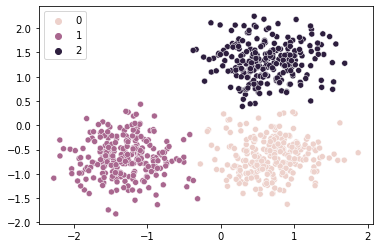

In [8]:
sns.scatterplot(x=ads_arr[:,0],y=ads_arr[:,1],hue=clusters_)

# Sklearn implementation for benchmarking

[[ 0.62260555  1.3172598 ]
 [ 0.6954587  -0.64442334]
 [-1.30266211 -0.65704205]]
212.39132249472704
4
(750,)


<AxesSubplot:>

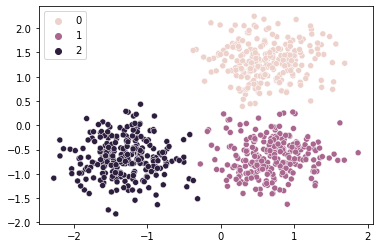

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

#---------------------------------------------------------------------------
kmeans = KMeans(n_clusters=3,n_init=1,max_iter=50,tol=1e-4,random_state=50)
kmeans.fit(ads_arr)
kmeans_labels = kmeans.labels_

#------------------------------------
#Generate Summary

print(kmeans.cluster_centers_)
print(kmeans.inertia_)
print(kmeans.n_iter_)
print(kmeans_labels.shape)
sns.scatterplot(x=ads_arr[:,0],y=ads_arr[:,1],hue=kmeans_labels)

### Insights : The results are matching

# Elbow plotting & Silhouette Curve for k-means

<AxesSubplot:title={'center':'Mean Silhouette Value Curve Mean_Sil_Value-vs-k'}, xlabel='K values', ylabel='Mean Sil Score'>

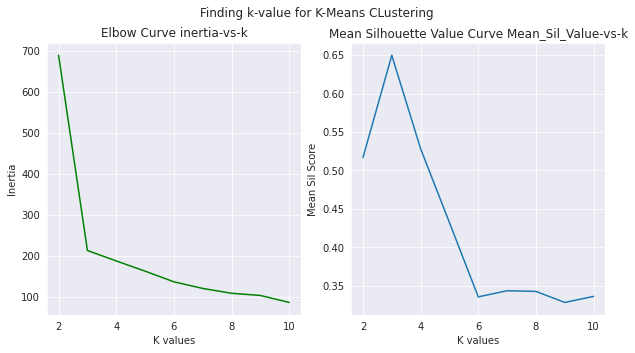

In [10]:
k_list = [2,3,4,5,6,7,8,9,10]
inertia_list = []
silhouette_list = []
silhouette_samples_list = []

#--------------------------------------------------------------------------------------------------------------
for k_ in k_list:

    kmeans = KMeans(n_clusters=k_,n_init=1,max_iter=50,tol=1e-4,random_state=50)
    kmeans.fit(ads_arr)
    
    #---------------------------------------------------------------------------
    inertia_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X=ads_arr,labels=kmeans.labels_))
    
#--------------------------------------------------------------------------------------------------------------    
sns.set_style('darkgrid')

#-----------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,5))

#-----------------------------------------------------------------------
fig.suptitle('Finding k-value for K-Means CLustering')
axes[0].set_title('Elbow Curve inertia-vs-k')
axes[1].set_title('Mean Silhouette Value Curve Mean_Sil_Value-vs-k')

axes[0].set(xlabel='K values',ylabel='Inertia')
axes[1].set(xlabel='K values',ylabel='Mean Sil Score')

#-----------------------------------------------------------------------
sns.lineplot(ax=axes[0],x=k_list, y=inertia_list,color='g')
sns.lineplot(ax=axes[1],x=k_list,y=silhouette_list)

## Insights : 
1. Inertia Elbow Curve suggests the best k value at 3 (which is the exact number of clusters present in the simulated data)
2. The sillhouette curve suggests highest sillhouette score at k=3, in concurrence with inertia elbow curve

# END